# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
import random
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing (Training Data: Introduction of Bills and Legislation from 6th Session to 7th Session, 2004-2012)

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 2021-05-20.csv',encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 2510 
 None-Pork Legislation 4733


#### (2) Tokenization

In [4]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

In [5]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [6]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


#### (4) Spliting Training/ Testing Set

In [7]:
data_labels = data.pork_bill.values

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (4852, 785) 
Shape of X Test : (2391, 785) 
Shape of Y Trian: (4852,) 
Shape of Y Test : (2391,)


In [9]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 4852 
 Not Pork vs Pork: {0: 3167, 1: 1685}


In [10]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 2391 
 Not Pork vs Pork: {0: 1566, 1: 825}


-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [11]:
class DCNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size,emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3,padding="valid",activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,kernel_size=4,padding="valid",activation="relu")
        self.fivegram = layers.Conv1D(filters=nb_filters,kernel_size=5,padding="valid",activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.fourgram(x)
        x_4 = self.pool(x_4) 
        x_5 = self.fivegram(x)
        x_5 = self.pool(x_5)      
        merged = tf.concat([x_1, x_2, x_3, x_4, x_5], axis=-1) 
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output

In [12]:
VOCAB_SIZE = tokenizer.vocab_size  # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.2
BATCH_SIZE = 220
NB_EPOCHS = 80

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [13]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (train_inputs.shape[1] , EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)  (785 , EMB_DIM)
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  586600    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  100100    
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  128256 

#### (3) Check Point Path

In [14]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

-------------------------

### Stage 4: Train the Model

In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [16]:
Dcnn.fit(train_inputs, train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop])
ckpt_manager.save()

Epoch 1/80
23/23 [==============================] - 51s 2s/step - loss: 0.6081 - accuracy: 0.6492 - val_loss: 0.5072 - val_accuracy: 0.7570
Epoch 2/80
23/23 [==============================] - 60s 3s/step - loss: 0.3766 - accuracy: 0.8502 - val_loss: 0.2449 - val_accuracy: 0.9030
Epoch 3/80
23/23 [==============================] - 61s 3s/step - loss: 0.1662 - accuracy: 0.9361 - val_loss: 0.1630 - val_accuracy: 0.9394
Epoch 4/80
23/23 [==============================] - 59s 3s/step - loss: 0.0815 - accuracy: 0.9744 - val_loss: 0.1517 - val_accuracy: 0.9456
Epoch 5/80
23/23 [==============================] - 62s 3s/step - loss: 0.0602 - accuracy: 0.9819 - val_loss: 0.1553 - val_accuracy: 0.9481
Epoch 6/80
23/23 [==============================] - 61s 3s/step - loss: 0.0489 - accuracy: 0.9843 - val_loss: 0.1662 - val_accuracy: 0.9473
Epoch 7/80
23/23 [==============================] - 64s 3s/step - loss: 0.0523 - accuracy: 0.9847 - val_loss: 0.1807 - val_accuracy: 0.9431
Epoch 8/80
23/23 [==

'checkpoint_recode/ckpt_manager/ckpt-1'

-------------------------

### Stage 5: Evaluation

In [17]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.608115,0.649217,0.507231,0.757005
1,0.376569,0.850165,0.244924,0.902969
2,0.166250,0.936109,0.163034,0.939356
3,0.081544,0.974444,0.151741,0.945629
4,0.060179,0.981863,0.155290,0.948139
5,0.048889,0.984336,0.166168,0.947302
6,0.052302,0.984749,0.180666,0.943120
7,0.046451,0.985161,0.177691,0.946884
8,0.037229,0.986603,0.175692,0.944375


<AxesSubplot:>

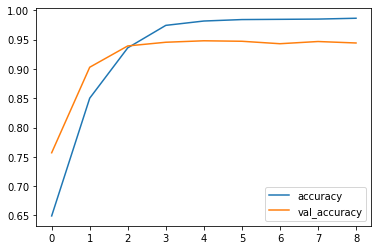

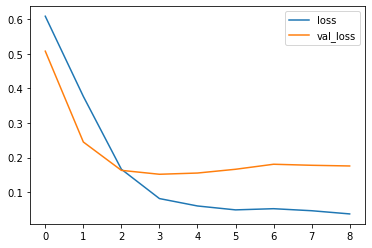

In [18]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

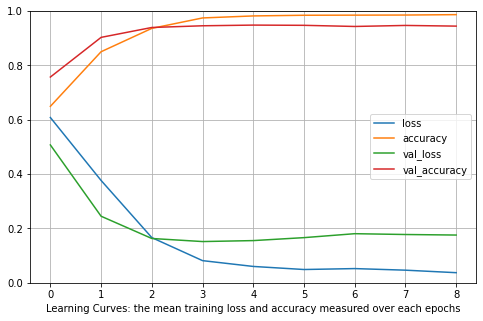

<Figure size 432x288 with 0 Axes>

In [34]:
losses.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel("Learning Curves: the mean training loss and accuracy measured over each epochs")
plt.show()
plt.savefig('images/learning_curves.png')

In [20]:
from sklearn.metrics import classification_report,confusion_matrix
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

11/11 [==============================] - 7s 634ms/step - loss: 0.1757 - accuracy: 0.9444
[0.17569226026535034, 0.9443747401237488]


In [21]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1566
           1       0.95      0.90      0.92       825

    accuracy                           0.95      2391
   macro avg       0.95      0.94      0.94      2391
weighted avg       0.95      0.95      0.95      2391



In [22]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),1525,41
Acutal: Pork (1),83,742


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 2000 samples from Legislative Questions from 6th Session 

In [23]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [24]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
random.seed(42)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Samples

In [25]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
1761,彭添富,0.998209238052368,針對「辦理九十四年原住民中低收入戶家庭租屋補助計畫」專案補助計畫，特向行政院提出質詢。,原住民族生活,原住民中低收入戶 ; 租屋補助
9892,陳啟昱,0.997866570949554,鑑於現行《所得稅法》第十七條規定特別扣除額教育支出部分，僅以納稅義務人之子女就讀大專院校為限...,所得稅 ; 教育費用 ; 扣除額,所得稅法 ; 特別扣除額 ; 教育支出
7382,盧秀燕,0.996699690818787,針對早期退除役軍官給與補助金發放金額過低，實無法解決終身生活所需，希望相關單位考量實際情況，...,榮民福利,早期退除役軍官給與補助金
10471,馮定國,0.995752215385437,鑒於國內經濟結構的快速調整，與人口高齡化的進展，未來中高齡失業問題必將日益嚴重，致使國人老年...,老人福利,高齡化 ; 中高齡失業
10735,黃志雄,0.992547392845154,針對樹林市三多地區三多國中新設案，因地方政府財務困難，無法如期支付龐大之建校費用，為維護樹林...,學校設立 ; 政府補助,三多國中 ; 建校費用
4553,林鴻池,0.991347432136536,針對行政院宣布補助弱勢家庭子女就讀私校高中職之學費，卻將資格限制在「非自願就讀者」，有畫餅充...,低收入戶 ; 教育補助,弱勢家庭 ; 私立高中職
8340,蔡煌瑯(離職),0.989324092864990,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費
9527,鄭朝明,0.988275885581970,針對我國生育率逐年下降，嚴重影響人口結構發展。民眾不願多生育子女，主因在於負擔費用過重，政府...,出生率 ; 人口政策,生育率 ; 人口 ; 人口老化
35,丁守中,0.979786992073059,針就民眾陳情指出，目前政府對身心障礙者提供之生活津貼，依身心障礙程度等級分為1000元至50...,身心障礙者福利,身心障礙者生活津貼
3999,林正峰,0.978763997554779,針對政府準備修法推動「二代健保」，健保保費採取「年度所得總額」為計算基礎，而非採用扣除免稅額...,國民 ; 健康保險 ; 保險費,二代健保 ; 年度所得總額


##### Last 10 Rows of 2000 Samples

In [26]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
5209,沈智慧,0.000004554513907,有鑒於台鐵意外頻傳，從訂票系統到五條人命的悲劇，日常班次也誤點連連，導致國人對台鐵的信心蕩然...,鐵路管理,台鐵管理
6532,王幸男,0.000004176607945,針對陳總統日昨重申，有信心一定能夠在二○○八年卸任總統之前，為台灣催生一部合身、合時、合用的...,憲法修正,新憲法 ; 修改憲法
9915,陳啟昱,0.000004027605883,鑒於近年來外籍配偶議題在台灣逐漸發酵，但因我國法令所囿，其國籍歸屬經常因為離婚或其他因素，而...,國籍 ; 外國人 ; 婚姻,外籍配偶 ; 離婚 ; 無國籍
3485,林德福,0.000003166892384,針對國內毒品市場再見新玩意，表示關切！一種名為「Ｎｅｘｕｓ」新興毒品，已入侵台灣。這種俗稱「...,毒品,毒品 ; Ｎｅｘｕｓ
7674,羅世雄,0.000003063877102,針對手機通訊業者辦理新辦戶及更換SIM卡程序中，出現犯罪集團持偽造身分證，藉此竊取個人資料，...,電信行政 ; 國民身分證 ; 隱私權 ; 偽造,手機 ; 竊取個人資料 ; 犯罪集團
1299,廖婉汝,0.000002923318334,針對近來警界風紀事件頻傳，身為人民保母的員警卻屢屢傳出知法犯法、違法亂紀的情形，嚴重侵害到人...,警察風紀,警界風紀
10120,陳朝龍,0.000002733298743,針對英國政府宣稱台灣出口至該國禽鳥，檢驗出感染禽流感H5N1病毒死亡。由於我國迄今並未發現有...,傳染病防治 ; 走私,英國政府 ; 台灣禽鳥 ; 禽流感 ; 相思鳥 ; 走私
5298,沈智慧,0.000002192776265,針對貴院謝院長長廷上任後，包括前第一金控董事長謝壽夫、台師大校長黃光彩先後去職；另包括內政部...,行政首長,部會首長 ; 道歉內閣
5595,潘孟安,0.000001794590162,就立法委員選舉，改採單一選區兩票制即將首度實施，中央選舉委員應加強宣導「單一選區兩票制」的新...,選舉,立法委員選舉 ; 單一選區兩票制
4356,林進興,0.000001685367920,針對行政院金融監督管理委員會為了解決國人廣大的卡債問題，積極推廣債務協商機制，政策本意良好，...,信用卡 ; 債務,卡債 ; 協商機制


#### (2) Export an End-to-end Model


In [27]:
from tensorflow.keras.models import load_model

In [28]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

INFO:tensorflow:Assets written to: lour_pork_model/assets


INFO:tensorflow:Assets written to: lour_pork_model/assets


In [29]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')